In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode as Inter
import copy
import json
import shutil
import pickle

from utils import set_random
from training_utils import train_validate_v2, validate
from model_v2 import deeplabv3_resnet50
from dataset import DataHandler, chose_labeled_auris, divide_data_split_auris
from routes import CLASS_ID_TYPE, CONTINUE_PATH, CONTINUE_FOLDER, FILE_TYPE, FRAME_KEYWORD, IMG_PATH, LAB_PATH, PRINT_PATH
from OF_query import OF_query, RAFT_query, RAFTxSim_query, density_OF_query
from other_queries import GT_query, GTxSim_query, density_entropy_query, density_query, entropy_query, random_query, similarity_query, k_means_fulldataset_center_query, k_means_entropy_query, k_means_fulldataset_entropy_query
from main import config

import matplotlib.pyplot as plt
from PIL import Image


/Users/feiwu/opt/anaconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATAPATH = '../../datasets/auris/auris_seg/'
IMG_PATH = DATAPATH + 'images/'
LAB_PATH = DATAPATH + 'labels/'

In [4]:
SEED = 0
set_random(SEED)
train_data, val_data, test_data = divide_data_split_auris(
    IMG_PATH, LAB_PATH)

In [5]:
test_imgTrans = T.Compose([
    T.Resize((config['IMG_SIZE'], config['IMG_SIZE']),
                interpolation=Inter.BILINEAR),
])
test_labelTrans = T.Compose([
    T.Resize((config['IMG_SIZE'], config['IMG_SIZE']),
                interpolation=Inter.NEAREST)
])

In [6]:
curr_labeled = collections.defaultdict(list)
ind_keyword = len(LAB_PATH + CLASS_ID_TYPE)
for i, (class_ID, data_paths) in enumerate(train_data.items()):
    inds = [int(0.5 * len(data_paths))]
    L = []
    for ind in inds:
        mask_path = data_paths[ind][1]
        number = mask_path[ind_keyword +
                            len(FRAME_KEYWORD):-len(FILE_TYPE)]
        L.append(number)
    curr_labeled[class_ID] = L

labeled_train, unlabeled_train, all_train = chose_labeled_auris(
                    train_data, labeled=curr_labeled)

In [7]:
all_train_dataset = DataHandler(data_path=all_train,
                                img_trans=test_imgTrans,
                                label_trans=test_labelTrans)
val_dataset = DataHandler(data_path=val_data,
                            img_trans=test_imgTrans,
                            label_trans=test_labelTrans)
test_dataset = DataHandler(data_path=test_data,
                            img_trans=test_imgTrans,
                            label_trans=test_labelTrans)

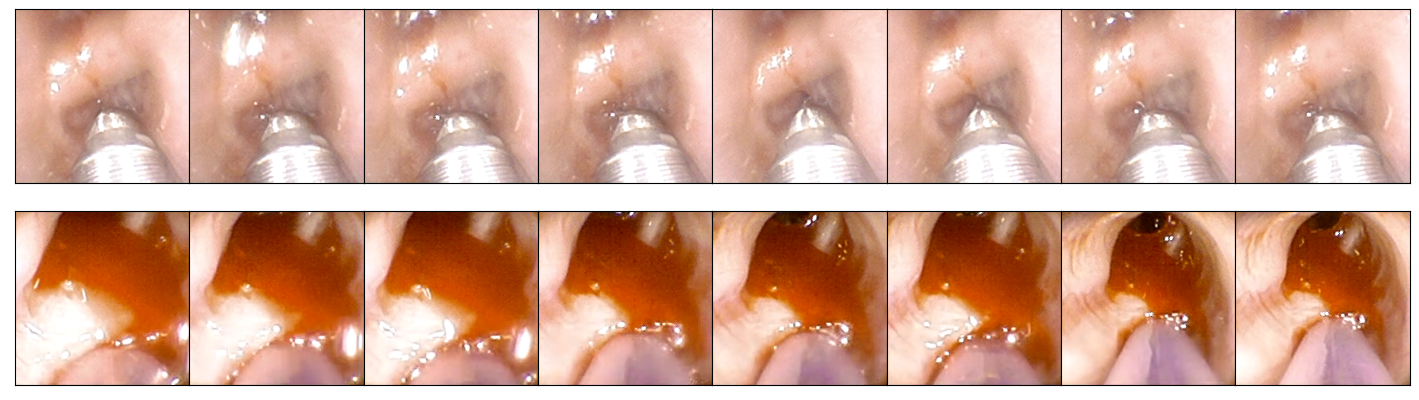

In [130]:
fig, axs = plt.subplots(2, 8, figsize=(18, 5))
# white space
fig.subplots_adjust(wspace=0, hspace=0.1)
for i in range(8):
    x, y, n = all_train_dataset[i + 350]
    axs[0, i].imshow(x.permute(1, 2, 0))

for i in range(8):
    x, y, n = val_dataset[i]
    axs[1, i].imshow(x.permute(1, 2, 0))

# ticks off
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('../../../MICCAI/seq_frames.pdf' , bbox_inches='tight')

In [8]:
LABEL_TO_COLORS = {'background': [0, 0, 0],
                    'REBUS Sheath': [0, 255, 0],
                    'needle clear sheath': [255, 0, 0],
                    'forceps sheath': [125, 0, 255],
                    'needle tip': [255, 125, 0],
                    'needle blue sheath': [255, 0, 125],
                    'needle brush': [255, 125, 125],
                    'forceps clamp': [0, 0, 255],
                    'REBUS Probe': [255, 255, 0],
                    'forceps blue': [0, 125, 255]}

In [9]:
data_pool = all_train_dataset.data_pool
data_pool = val_dataset.data_pool
data_pool = test_dataset.data_pool

In [10]:
len(data_pool)

1273

In [11]:
def good_img(class_color, y):
    for i, channel in enumerate(class_color):
        if np.sum(y[:, :, i] == channel) == 0:
            return False
    return True

In [12]:
img_per_class = {}
for k, v in LABEL_TO_COLORS.items():
    if k == 'background':
        continue
    for img_path, mask_path in data_pool:
        # x = Image.open(img_path)
        # x = np.array(x)
        y = Image.open(mask_path)
        y = np.array(y)
        if good_img(v, y):
            img_per_class[k] = (img_path, mask_path)
            break

In [91]:
# all img
img_per_class

{'REBUS Sheath': ('../../datasets/auris/auris_seg/images/08-01/frame23582.png',
  '../../datasets/auris/auris_seg/labels/08-01/frame23582.png'),
 'needle clear sheath': ('../../datasets/auris/auris_seg/images/10-04/frame45957.png',
  '../../datasets/auris/auris_seg/labels/10-04/frame45957.png'),
 'forceps sheath': ('../../datasets/auris/auris_seg/images/10-06/frame51132.png',
  '../../datasets/auris/auris_seg/labels/10-06/frame51132.png'),
 'needle tip': ('../../datasets/auris/auris_seg/images/10-04/frame45957.png',
  '../../datasets/auris/auris_seg/labels/10-04/frame45957.png'),
 'needle blue sheath': ('../../datasets/auris/auris_seg/images/10-04/frame45957.png',
  '../../datasets/auris/auris_seg/labels/10-04/frame45957.png'),
 'needle brush': ('../../datasets/auris/auris_seg/images/10-04/frame45957.png',
  '../../datasets/auris/auris_seg/labels/10-04/frame45957.png'),
 'forceps clamp': ('../../datasets/auris/auris_seg/images/10-06/frame50332.png',
  '../../datasets/auris/auris_seg/la

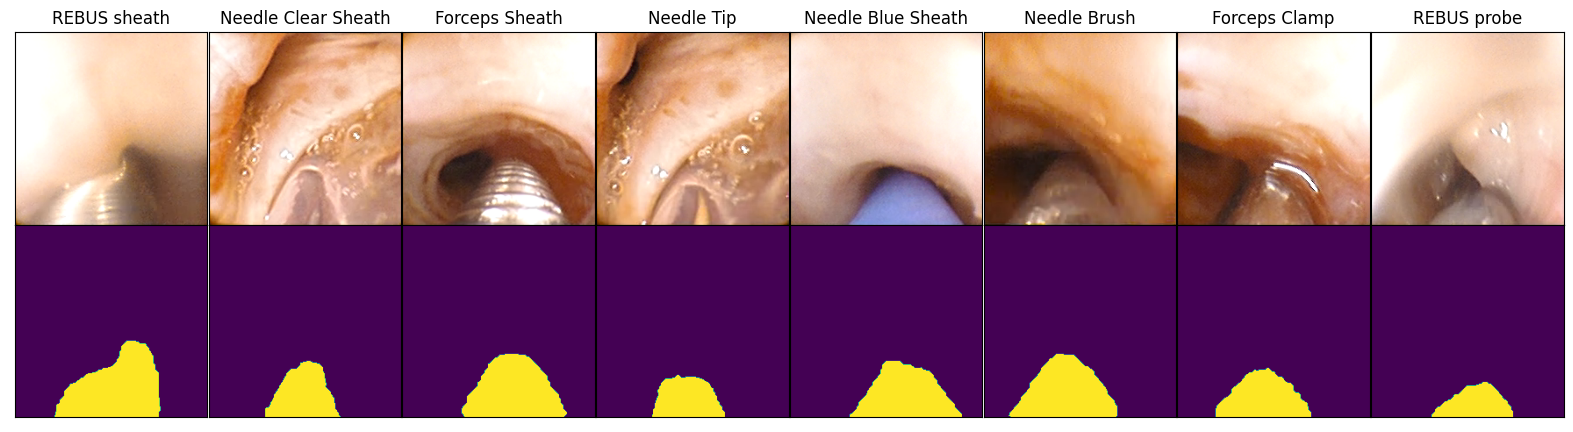

In [14]:
fig, axs = plt.subplots(2, 8, figsize=(20, 5))
# reduce white space
fig.subplots_adjust(wspace=0, hspace=0)
for i, (k, (img_path, mask_path)) in enumerate(img_per_class.items()):
    x = Image.open(img_path)
    x = np.array(x)
    y = Image.open(mask_path).convert('L')
    y = np.array(y)
    y = y != 0
    axs[0, i].imshow(x)

    k = k.split(' ')
    for j, kk in enumerate(k):
        k[j] = kk.capitalize()
    k = ' '.join(k)

    if k == 'Rebus Sheath':
        k = 'REBUS sheath'
    elif k == 'Rebus Probe':
       k = 'REBUS probe'

    axs[0, i].set_title(k)
    axs[1, i].imshow(y)
    # ticks off
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

plt.savefig('../../../MICCAI/dataset.pdf', bbox_inches='tight')

In [108]:
y.shape

(220, 220)